# Exercise 3 - Binary Classification with Logistic Regression

This exercise is meant to familiarize you with the complete pipeline of solving a machine learning problem. You
need to obtain and pre-process the data, develop, implement and train a machine learning model and evaluate it
by splitting the data into a train and testset.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
30.04.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

## Data Preparation

In the model of **logistic regression**, we have $m$ samples $x_i\in\mathbb{R}^n$ with labels $y_i\in\{-1,1\}$.

In this exercise, we will use the equivalent formulation with $y_i\in\{0,1\}$.
We use the example dataset `data.npy`, where we have 2 dimensional features (first two columns) and a binary label (3rd column).

### Task 1
Load and split the dataset into samples and labels. Then plot the data with a scatterplot and use different colors for different labels.

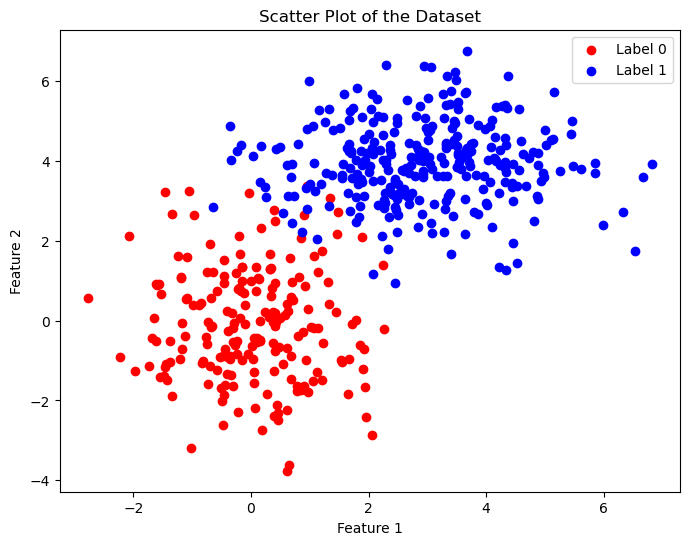

In [168]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: Load and split dataset
dataset = np.load("data.npy")
x = dataset[:, [0,1]]
y = dataset[:, 2]
assert x.shape == (500, 2)
assert y.shape == (500,)
# TODO: plot the data

plt.figure(figsize=(8, 6))
# Using different colors for different labels
plt.scatter(x[y == 0][:, 0], x[y == 0][:, 1], c='red', label='Label 0')
plt.scatter(x[y == 1][:, 0], x[y == 1][:, 1], c='blue', label='Label 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of the Dataset')
plt.legend()
plt.show()

## Model



The function $\sigma$ is called the logistic *sigmoid function*:

\begin{align}
\sigma(a) = \cfrac{1}{1+\exp(-a)}\ .
\end{align}


###  Task 2
Implement a vectorized logistic sigmoid function, i.e. it takes a vector of x-coordinates X and returns a vector of their respective y values. Use it to plot the function between -10 and 10.

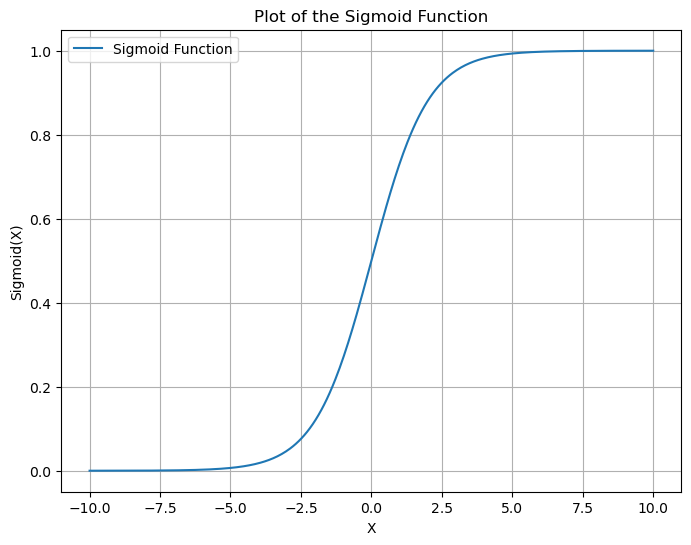

In [169]:
def sigmoid(x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Sigmoid function.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Array of any dimension with scalar entries.

    Returns
    -------
    npt.NDArray[np.float64]
        Array of the same shape as the input with the sigmoid function applied element-wise.
    """

    # TODO: implement
    return 1 / (1 + np.exp(-x))


# TODO: Plot function from -10 to 10
# Generate a range of values from -10 to 10
X = np.linspace(-10, 10, 400)

# Apply the sigmoid function to these values
Y = sigmoid(X)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(X, Y, label="Sigmoid Function")
plt.xlabel("X")
plt.ylabel("Sigmoid(X)")
plt.title("Plot of the Sigmoid Function")
plt.grid(True)
plt.legend()
plt.show()

The goal in logistic regression is to find the parameter vector $\theta\in\mathbb{R}^n$, so that 

\begin{align}
p(y_i=1|x_i,\theta)&=\sigma(x_i^T\theta)\\
p(y_i=0|x_i,\theta)&=1-p(y_i=1|x_i,\theta)
\end{align}

fits our data and can be used to predict the label on unseen data (binary classification).


With an estimated $\theta$, a new feature $x\in\mathbb{R}^n$ is classified according to:

\begin{align}
\hat{y} = \begin{cases}
1&\text{, if }p(y=1|x,\theta)\geq 0.5\\
0&\text{, else}
\end{cases}.
\end{align}

Since $\sigma(0) =  1/(1+\exp(0)) = 0.5$. This is equivalent to 
\begin{align}
\hat{y} = \begin{cases}
1&\text{, if } x_i^T\theta \geq 0\\
0&\text{, else}
\end{cases}
\end{align}
 as noted in the lecture.

### Task 3
Prepare `x` so that the classification function for an estimated $\theta$ is [*affine*](https://math.stackexchange.com/questions/275310/what-is-the-difference-between-linear-and-affine-function). Add this affine component at the **first column**.

In [170]:
# TODO: Prepare x
x = np.hstack([np.ones((x.shape[0], 1)), x])
assert x.shape == (500, 3)

### Task 4

Implement a `predict` function based on the above definition of probabilities.

In [171]:
def predict(x: npt.NDArray[np.float64], theta: npt.NDArray[np.float64]) -> npt.NDArray[np.bool_]:
    """Predicts Y given X and theta.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Matrix with datapoints as rows (m x n).
    theta : npt.NDArray[np.float64]
        Parameter vector (n).

    Returns
    -------
    npt.NDArray[np.float64]
        Vector of predictions (m).
    """

    # TODO: implement
    return x @ theta >= 0


# assertions
np.random.seed(0)
theta_assertion = np.array([-2, 0.5, 1])
x_assertion = np.array([
    [1, 1, 0],
    [1, 0, 1],
    [1, 1, 1],
    [1, 0, 3],
    [1, 2, 2],
    [1, 5, 0],
    [1, 0, 2]
])
y_assertion = predict(x_assertion, theta_assertion)
assert np.all(y_assertion == [False, False, False, True, True, True, True])

## Learning $\theta$

For a given $\theta$, we can calculate $p(y|x,\theta)$ and use this probability for classification.
To evaluate how well a learned $\theta$ can be used to classify our data, we define a *loss function*.
Here we want to use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) given as:

\begin{align}
L(\theta) = -\cfrac{1}{m}\sum_{i=1}^m y_i\log(p(y_i=1|x_i,\theta))+(1-y_i)\log(1-p(y_i=1|x_i,\theta))
\end{align}

Often it is convenient to have multiple metrics at hand. In classification problems, the *accuracy* of a
prediction is defined as the percentage of correctly classified features. In the case of logistic regression, this corresponds to 

\begin{align}
Acc(\theta) = \cfrac{1}{m}\sum_{i=1}^m y_i \hat{y_i} + (1-y_i)(1-\hat{y_i})
\end{align}
where $\hat{y_i}$ is the prediction for $x_i$.

As our model becomes better, we expect the accuracy to increase and the loss to decrease.  

### Task 5
Implement the binary cross entropy and the accuracy for logistic regression. 

In [172]:
def cross_entropy_loss(x: npt.NDArray[np.float64], y: npt.NDArray[np.float64], theta: npt.NDArray[np.float64]) -> float:
    """Computes the binary cross entropy loss of the model.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Matrix with datapoints as rows (m x n).
    y : npt.NDArray[np.float64]
        Vector of true labels (m).
    theta : npt.NDArray[np.float64]
        Parameter vector (n).

    Returns
    -------
    float
        Binary cross entropy (scalar).
    """

    # TODO: implement
    m = len(y)  # number of samples
    probabilities = predict_probabilities(x, theta)
    loss = - 1/m * (y @ np.log(probabilities + 1e-9) + (1 - y) @ np.log(1 - probabilities + 1e-9))
    return loss

def predict_probabilities(x: npt.NDArray[np.float64], theta: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Predicts probabilities given X and theta, using the logistic sigmoid function."""
    return sigmoid(x @ theta)

def accuracy(x: npt.NDArray[np.float64], y: npt.NDArray[np.float64], theta: npt.NDArray[np.float64]) -> float:
    """Computes the accuracy of the model.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Matrix with datapoints as rows (m x n).
    y : npt.NDArray[np.float64]
        Vector of true labels (m).
    theta : npt.NDArray[np.float64]
        Parameter vector (n).

    Returns
    -------
    float
        Accuracy (scalar).
    """
    m = len(y)
    probabilities = predict(x,theta)
    return 1/m * ((y @ probabilities.T) + ((1-y) @ (1-probabilities.T)))


assert np.isclose(cross_entropy_loss(x, y, theta_assertion), 0.13431393626196375, atol=1e-2)
assert np.isclose(accuracy(x, y, theta_assertion), 0.964)

Given the loss function $L(\theta)$, we want to minimize this function with respect to the parameters $\theta$, that is we are looking for

\begin{align}
    \text{argmin}_\theta L(\theta)
\end{align}

However, since this is a highly nonlinear optimization problem, we use an iterative approach that starts with an initial estimate for $\theta$ and approaches the solution at each iteration step. 
The most simple approach is to take the gradient
$\nabla L(\theta)$ of $L(\theta)$ with respect to $\theta$ and walk into direction of the negative gradient. 
This method is called gradient-descent.

### Task 6

Find out $\nabla L(\theta) = \cfrac{d L}{d \theta}$ and implement this function.
The resulting function takes features $X$, labels $Y$ and $\theta$ as input and outputs a gradient $\nabla L(\theta)\in\mathbb{R}^n$.

Again, test your function with a randomly chosen $\theta$.

In [173]:
def cross_entropy_gradient(x: npt.NDArray[np.float64], y: npt.NDArray[np.float64], theta: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Computes the gradient of the binary cross entropy loss with respect to theta.

    Parameters
    ----------
    x : npt.NDArray[np.float64]
        Matrix with datapoints as rows (m x n).
    y : npt.NDArray[np.float64]
        Vector of true labels (m).
    theta : npt.NDArray[np.float64]
        Parameter vector (n).

    Returns
    -------
    npt.NDArray[np.float64]
        Gradient at point theta (n).
    """

    # TODO: implement
    m = x.shape[0] 
    probabilities = sigmoid(x @ theta)
    gradient = -1 / m * x.T @ (y - probabilities)
    return gradient


# assertions
assert np.allclose(cross_entropy_gradient(x, y, theta_assertion), [0.03666132, -0.05252688, -0.01899831], atol=1e-2)

### Task 7
Implement the fit function for the following Logistic Regression class:

 1. (randomly) choose initial $\hat{\theta}$
 2. update $\hat{\theta} \leftarrow \hat{\theta} -\eta\nabla L(\hat{\theta})$
 3. repeat 2. until a maximum number of iterations $\lambda$ (parameter `max_it`) is reached or the loss did not change more than $\varepsilon$ (parameter `eps`).
 
The hyperparameter $\eta$ is also called *learning rate* (parameter `lr`).

Additionaly track the losses and accuracies that occur during the iterations of gradient descend. 

Test your class (on the prepared data from above) and plot the accuracies and losses over the iterations.

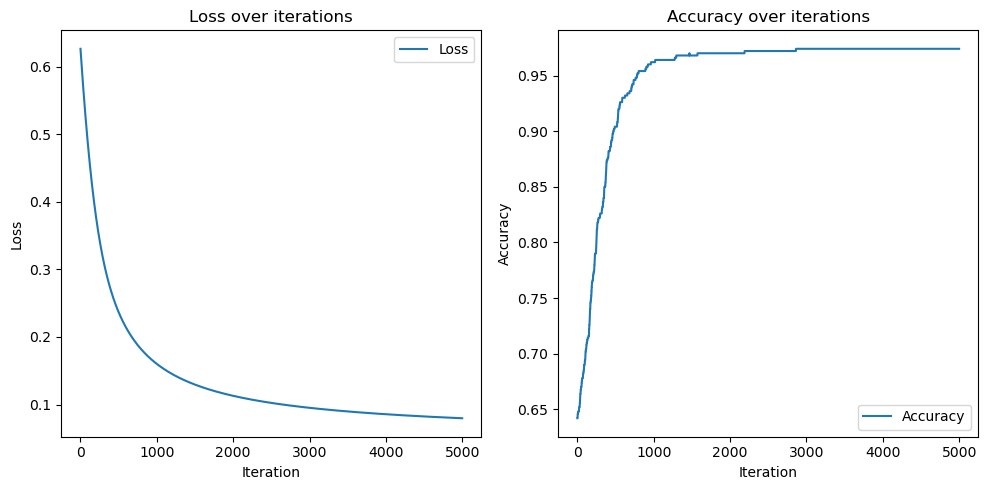

In [174]:
from typing import Self


class LogisticRegressor():
    def __init__(self, learn_rate: float = 1e-2, max_iterations: int = 1000, epsilon: float = 1e-5):
        """Regressor for binary classification using logistic regression. Fits using gradient descent.

        Parameters
        ----------
        learn_rate : float, optional
            Learning rate, sets step size for descent, by default 1e-2.
        max_iterations : int, optional
            Maximum number of descent steps, by default 1000.
        epsilon : float, optional
            Descent stops early if the loss did not change more than this, by default 1e-5.
        """

        self.learn_rate = learn_rate
        self.max_iterations = max_iterations
        self.epsilon = epsilon
        self.theta = None
        self.accuracies = []
        self.losses = []

    def predict(self, x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        """Predicts Y given X and learned theta.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).

        Returns
        -------
        npt.NDArray[np.float64]
            Array of predictions (m).
        """

        probabilities = predict_probabilities(x, self.theta)
        return probabilities >= 0.5

    def fit(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]) -> Self:
        """Gradient descent for binary crossentropy. Starts at a random parameter vector and tracks losses and accuracies along the iterations.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            Matrix with datapoints as rows (m x n).
        y : npt.NDArray[np.float64]
            Vector of true labels (m).
        """

        # TODO: implement
        self.theta = np.random.rand(x.shape[1])
        
        for iteration in range(self.max_iterations):
            current_loss = cross_entropy_loss(x, y, self.theta)
            self.losses.append(current_loss)
            gradients = cross_entropy_gradient(x, y, self.theta)
            self.theta -= self.learn_rate * gradients
            
            # Calculate accuracy
            predictions = predict_probabilities(x, self.theta) >= 0.5
            accuracy = np.mean(predictions == y)
            self.accuracies.append(accuracy)

            # Check for convergence
            if iteration > 0 and abs(self.losses[-2] - self.losses[-1]) < self.epsilon:
                break
                
        return self


# assertions
np.random.seed(0)
regressor = LogisticRegressor(max_iterations=5000, epsilon=0).fit(x, y)
assert np.allclose(regressor.theta, [-2.77171607, 0.99485879, 1.07592613], atol=1e-2)

# TODO: plot accuracy and loss
np.random.seed(0)
x_prepared = np.hstack([np.ones((x.shape[0], 1)), x])
regressor = LogisticRegressor(max_iterations=5000, learn_rate=0.01, epsilon=1e-6).fit(x_prepared, y)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(regressor.losses, label='Loss')
plt.title('Loss over iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(regressor.accuracies, label='Accuracy')
plt.title('Accuracy over iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Task 8

So far, we used the whole dataset for fitting the `LogReg` class.

- Use [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into train (75%) and testset (25%).
- Fit the Logistic Regression model on the trainset and calculate the final accuracies on the train and testset. 
- Experiment with the hyperparameters for fit, to get a good result.

In [175]:
from sklearn.model_selection import train_test_split

# TODO: Split data into train and test data
x_train, x_test, y_train, y_test = train_test_split(x_prepared, y, test_size=0.25, random_state=42)

# TODO: apply logistic regression
regressor = LogisticRegressor(max_iterations=5000, learn_rate=0.01, epsilon=1e-6)
regressor.fit(x_train, y_train)

# TODO: determine train and test accuracy
train_accuracy = np.mean(regressor.predict(x_train) == y_train)
test_accuracy = np.mean(regressor.predict(x_test) == y_test)

## Visualization

Next we want to visualize our classifier. To to this, we want to visualize the *decision boundary* defined by $\hat{\theta}$.

The decision boundary is defined as 
$
\{x\in\mathbb{R}^n: p(y=1|x)=0.5\}
$
or as in the lecture:
$\{x\in \{1\} \times \mathbb{R}^n: x^T\hat{\theta}=0\}$


### Task 9

Implement a function `plot_dec_boundary` that visualizes the data and the regression line for 2 dimensional samples $X$ and an estimated $\hat{\theta}$.

Test this function with the $\hat{\theta}$ estimated in Task 8.

[-2.71898274  0.98097821  1.06358395]


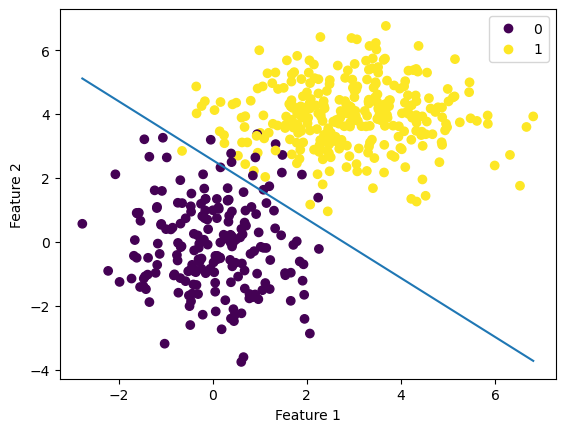

In [176]:
def plot_dec_boundary(x1: npt.NDArray, x2: npt.NDArray, y: npt.NDArray, theta: npt.NDArray):
    """Plots the decision boundary for 2D logistic regression task.

    Parameters
    ----------
    x : npt.NDArray
        Matrix with datapoints as rows (m x 2).
    y : npt.NDArray
        Vector of true labels (m).
    theta : npt.NDArray
        Parameter vector (3).
    """

    # TODO: plot data and decision boundary
    scatter = plt.scatter(x1, x2, c=y)
    x1= np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), 100)
    x2= -(theta[0] + theta[1]*x1)/theta[2]
    plt.plot(x1, x2, label= "Decision Boundary")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(*scatter.legend_elements())
    plt.show()


# TODO: visualize the decision boundary you learned
regressor.fit(x, y)
print(regressor.theta)
plot_dec_boundary(x[:, 1], x[:, 2], y, regressor.theta)

### Task 10

Use the [implementation from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to train a logistic regressor.

Visualize the regression line that you obtain with scikit learn.

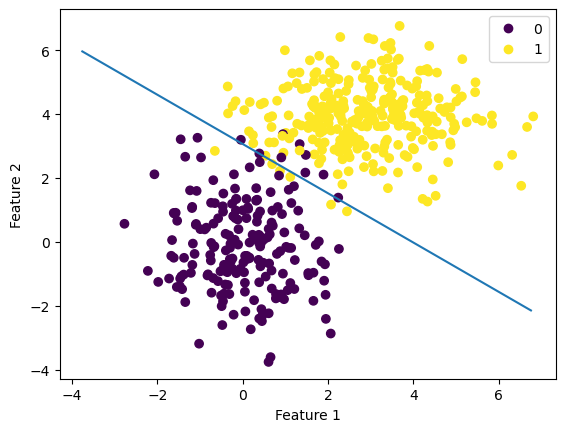

In [177]:
# TODO: estimate theta with scikit-learn
x = dataset[:, [0,1]]
y = dataset[:, 2]

model = LogisticRegression()
model.fit(x, y)
theta = np.hstack([model.intercept_, model.coef_.ravel()])


# TODO: plot regression line with data

plot_dec_boundary(x[:, [0]], x[:, [1]], y, theta)